# Задача: Анализ эффективности нового алгоритма рекомендаций в условиях асимметричного и зашумленного распределения
### Контекст:
Крупная стриминговая платформа (аналог YouTube или Twitch) разработала новый алгоритм рекомендаций контента (алгоритм B), который, как ожидается, должен увеличить среднее время просмотра на пользователя по сравнению со старым алгоритмом (A).

Было проведено A/B-тестирование:

- **Группа A (Контрольная)**: 5000 пользователей, старый алгоритм.

- **Группа B (Тестовая)**: 5000 пользователей, новый алгоритм.

По итогам двухнедельного теста вы собрали данные по ключевой метрике — **«Общее время просмотра на пользователя за тест (в минутах)»**.

**Данные и их особенности:**

**Не нормальность:** Распределение метрики в обеих группах сильно отличается от нормального. Оно имеет типичный для поведенческих данных "длинный хвост":

- Большинство пользователей смотрят немного (пик в районе 0-50 минут).

- Небольшая группа "супер-зрителей" смотрит очень много (сотни и тысячи минут), формируя длинный правый хвост распределения.

**Асимметрия влияния:** Новый алгоритм B целенаправленно меняет опыт именно активных пользователей, в то время как для "пассивных" зрителей разница неочевидна. Это означает, что различие между группами может быть не сдвигом всего распределения, а изменением в правом хвосте.

**Наличие выбросов:** В данных присутствуют экстремальные выбросы (например, пользователи, которые оставляли видео фоном на всю ночь).

Вам предоставлен датасет _ab_test_results.csv_ со следующими колонками:

 - _user_id_

 - _group (A или B)_

 - _total_watch_time_min_

### Задания:


- **Проведите тест Манна-Уитни (Mann-Whitney U test)**. Сформулируйте нулевую и альтернативную гипотезы. Интерпретируйте p-value. Можно ли на его основе сделать однозначный вывод о превосходстве алгоритма B?

- Чтобы исследовать "асимметричное влияние", проведите анализ разниц не только в центре распределения, но и в хвостах. **Рассчитайте и визуализируйте разницу между группами для 75-го, 90-го и 95-го процентилей**.

- **Сформулируйте итоговый вывод:**

    - Эффективен ли новый алгоритм B?

    - На какую именно группу пользователей он оказывает наибольшее влияние?

    - Какой метод анализа оказался наиболее информативным в данном случае и почему?

    - Дайте рекомендацию о возможности запуска алгоритма на всю аудиторию.



# Домашнее задание (модуль 2)
## Анализ эффективности нового алгоритма рекомендаций (A/B-тест)

**Контекст:** сравниваем группы `A` (старый алгоритм) и `B` (новый алгоритм) по метрике
`total_watch_time_min` -> общее время просмотра за тест (в минутах) на пользователя.

Особенности данных:
- распределение сильно не нормальное (длинный правый хвост);
- эффект может проявляться в хвостах (активные пользователи);
- есть экстремальные выбросы.

**План:**
1. Загрузка и базовая проверка данных.
2. Описательная статистика.
3. Разница в 75 / 90 / 95 перцентилях (как анализ хвостов).
4. Mann–Whitney U test + интерпретация p-value.
5. Итоговый вывод.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# --- 1. Загрузка данных ---
# Датасет лежит рядом с ноутбуком в homework_tasks/homework02/
CSV_PATH = "ab_test_results.csv"

df = pd.read_csv(CSV_PATH)

# Быстрый просмотр структуры
print("Columns:", list(df.columns))
print(df.head(5))

Columns: ['user_id', 'group', 'total_watch_time_min']
      user_id group  total_watch_time_min
0  user_08034     B             52.919097
1  user_07122     B             26.989693
2  user_07571     B             19.594523
3  user_07347     B             24.586337
4  user_03246     A             27.613320


In [2]:
# --- 2. Базовые проверки данных ---

# Размер датасета
print("\nDataset Summary:")
print(f"Total rows: {len(df)}")

# Проверяем, что группы действительно A/B
print("\nGroup value counts:")
print(df["group"].value_counts(dropna=False))

# Проверяем пропуски
print("\nMissing values:")
print(df.isna().sum())

# Проверяем дубликаты пользователей (если user_id должен быть уникальным)
dup_user_ids = df["user_id"].duplicated().sum()
print(f"\nDuplicated user_id count: {dup_user_ids}")

# Проверяем, что метрика не отрицательная
negative_metric = (df["total_watch_time_min"] < 0).sum()
print(f"Negative total_watch_time_min count: {negative_metric}")

# Фильтруем Nan
df_clean = df.dropna(subset=["group", "total_watch_time_min"]).copy()

# Фиксируем выборки
group_a = df_clean.loc[df_clean["group"] == "A", "total_watch_time_min"].astype(float)
group_b = df_clean.loc[df_clean["group"] == "B", "total_watch_time_min"].astype(float)

print("\nCleaned dataset:")
print(f"Total rows (clean): {len(df_clean)}")
print(f"Group A users: {len(group_a)}")
print(f"Group B users: {len(group_b)}")


Dataset Summary:
Total rows: 10000

Group value counts:
group
B    5000
A    5000
Name: count, dtype: int64

Missing values:
user_id                 0
group                   0
total_watch_time_min    0
dtype: int64

Duplicated user_id count: 0
Negative total_watch_time_min count: 0

Cleaned dataset:
Total rows (clean): 10000
Group A users: 5000
Group B users: 5000


In [3]:
# --- 3. Описательная статистика ---
# describe() дает count/mean/std/min/25%/50%/75%/max
desc = df_clean.groupby("group")["total_watch_time_min"].describe()

print("\nDescriptive Statistics by Group:")
print(desc)

# Медиана и среднее отдельно
print("\nExtra summary:")
print(df_clean.groupby("group")["total_watch_time_min"].agg(["mean", "median", "std", "min", "max"]))


Descriptive Statistics by Group:
        count       mean         std  min        25%        50%        75%  \
group                                                                        
A      5000.0  56.347878  262.313288  0.0  14.729144  26.834960  44.946309   
B      5000.0  71.477408  408.519252  0.0  15.383838  27.352416  46.352279   

                max  
group                
A       8130.547119  
B      11670.621483  

Extra summary:
            mean     median         std  min           max
group                                                     
A      56.347878  26.834960  262.313288  0.0   8130.547119
B      71.477408  27.352416  408.519252  0.0  11670.621483


In [4]:
# --- 4. Анализ хвостов: перцентили 75 / 90 / 95 ---

percentiles = [0.75, 0.90, 0.95]

print("\nKey Percentiles by Group:")

rows = []
for p in percentiles:
    p_label = int(p * 100)

    # np.percentile принимает проценты 0..100
    a_val = np.percentile(group_a, p * 100)
    b_val = np.percentile(group_b, p * 100)
    diff = b_val - a_val

    rows.append({"percentile": p_label, "A": a_val, "B": b_val, "B_minus_A": diff})

    print(f"{p_label}th percentile: A={a_val:.1f}, B={b_val:.1f}, Difference={diff:.1f}")

percentiles_df = pd.DataFrame(rows)
percentiles_df


Key Percentiles by Group:
75th percentile: A=44.9, B=46.4, Difference=1.4
90th percentile: A=71.5, B=76.2, Difference=4.7
95th percentile: A=119.3, B=153.6, Difference=34.3


,percentile,A,B,B_minus_A
0,75,44.946309,46.352279,1.405970
1,90,71.515837,76.237052,4.721214
2,95,119.342758,153.618178,34.275421


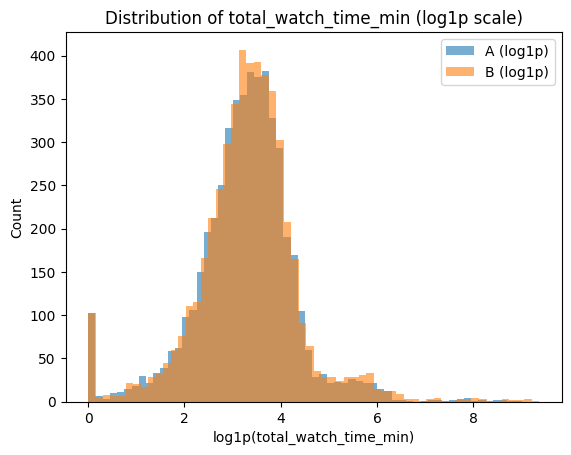

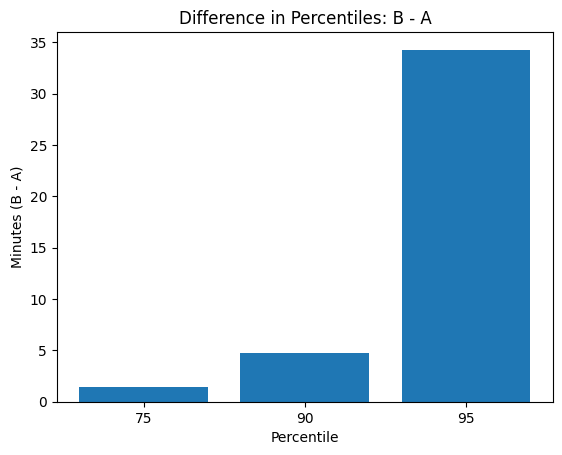

In [5]:
# --- 5. Визуализация распределений ---
# heavy-tail => логарифмируем для читаемости
a_log = np.log1p(group_a)
b_log = np.log1p(group_b)

plt.figure()
plt.hist(a_log, bins=60, alpha=0.6, label="A (log1p)")
plt.hist(b_log, bins=60, alpha=0.6, label="B (log1p)")
plt.title("Distribution of total_watch_time_min (log1p scale)")
plt.xlabel("log1p(total_watch_time_min)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Барчарт разницы перцентилей
plt.figure()
plt.bar(percentiles_df["percentile"].astype(str), percentiles_df["B_minus_A"])
plt.title("Difference in Percentiles: B - A")
plt.xlabel("Percentile")
plt.ylabel("Minutes (B - A)")
plt.show()

## Проверка гипотез (Mann–Whitney U)

**Нулевая гипотеза (H0):** распределения `total_watch_time_min` в группах A и B одинаковы
(в терминах теста нет систематического сдвига, P(X_B > X_A) = 0.5).

**Альтернативная гипотеза (H1):**
- двусторонняя: распределения различаются (есть сдвиг в любую сторону)
- односторонняя (в контексте "B лучше") -> значения в группе B статистически больше, чем в A

In [6]:
# --- 6. Mann–Whitney U test ---

# 1) two-sided -> проверяем, есть ли различия
# 2) greater -> "B статистически больше A"

u_two, p_two = stats.mannwhitneyu(group_a, group_b, alternative="two-sided", method="asymptotic")
u_greater, p_greater = stats.mannwhitneyu(group_a, group_b, alternative="less", method="asymptotic")
# Пояснение: alternative="less" при (group_a, group_b) означает H1: A < B

print("\nMann–Whitney U Test Results:")
print(f"two-sided p-value = {p_two:.6f}")
print(f"one-sided (B > A) p-value = {p_greater:.6f}")

# --- 7. Размер эффекта ---

# Common Language Effect Size (CLES): P(X_B > X_A) примерно равен U / (nA*nB)
# Если CLES > 0.5 => чаще значения из B больше, чем из A
n_a = len(group_a)
n_b = len(group_b)

cles = u_two / (n_a * n_b)
print(f"\nEffect size (CLES ~ P(A < B)): {cles:.4f}")

# Rank-biserial correlation = 2*CLES - 1 (диапазон [-1, 1])
rbc = 2 * cles - 1
print(f"Effect size (rank-biserial correlation): {rbc:.4f}")


Mann–Whitney U Test Results:
two-sided p-value = 0.045342
one-sided (B > A) p-value = 0.022671

Effect size (CLES ~ P(A < B)): 0.4884
Effect size (rank-biserial correlation): -0.0231


### Статистические гипотезы

**H0 (нулевая гипотеза):**
Распределения общего времени просмотра пользователей в группах A и B одинаковы.

**H1 (альтернативная гипотеза):**
Распределение времени просмотра в группе B сдвинуто в сторону больших значений
по сравнению с группой A (алгоритм B увеличивает вовлеченность).

### Итоговый вывод

1. По результатам Mann–Whitney U теста:
   - двухсторонний p-value ~ 0.045 < 0.05,
   - односторонний p-value (B > A) ~ 0.023.

   Это позволяет отвергнуть H0 на уровне значимости 5%.

2. Анализ перцентилей показал:
   - минимальные различия в центре распределения,
   - резкий рост эффекта на 90-м и особенно 95-м перцентилях.

3. Новый алгоритм B оказывает наибольшее влияние на **активных пользователей**,
   правый хвост распределения.

4. Наиболее информативным методом анализа оказался
   **перцентильный анализ в сочетании с U-тестом**,
   так как средние значения искажаются выбросами.

**Итог:**
Алгоритм B целесообразно запускать, если бизнес-целью является
рост вовлеченности активной аудитории.